In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [2]:
nltk.download('stopwords')
original_stopwords = set(stopwords.words('english'))
# Preserve important negation words
negation_words = {"not", "no", "nor", "neither", "never", "n't", "cannot", "n't"}
stop_words = original_stopwords - negation_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SREE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
fake_df=pd.read_csv("Fake.csv")

In [4]:
print(fake_df.head(5))

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  


In [5]:
true_df=pd.read_csv("True.csv")

In [6]:
print(true_df.head(5))

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   


In [7]:
# Label
fake_df['label']=0  #FAKE
true_df['label']=1  #TRUE

In [8]:
# CONCATENATE
df=pd.concat([fake_df,true_df],ignore_index="True")

In [9]:
print(df.shape)
print(df.columns)

(44898, 5)
Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [10]:
print(df['label'].value_counts())

label
0    23481
1    21417
Name: count, dtype: int64


In [11]:

df.head(5)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [12]:
print(df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [13]:
print(df.duplicated().sum())

209


In [14]:
df['date']=pd.to_datetime(df['date'],errors='coerce')

In [15]:
df['text_length']=df['text'].apply(lambda x: len(str(x).split()))
df['title_length']=df['title'].apply(lambda x: len(str(x).split()))

In [16]:
df.groupby('label')['text_length'].mean()

label
0    423.197905
1    385.640099
Name: text_length, dtype: float64

In [17]:
df.groupby('label')['title_length'].mean()

label
0    14.732805
1     9.954475
Name: title_length, dtype: float64

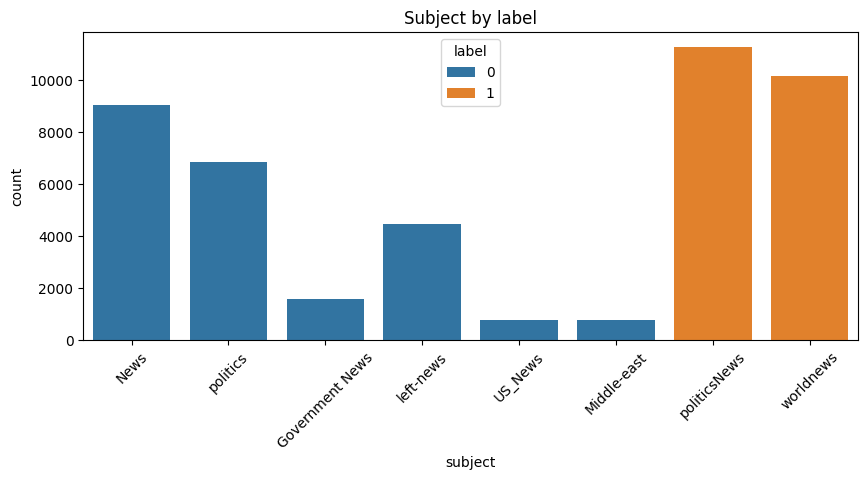

In [18]:
plt.figure(figsize=(10,4))
sns.countplot(x='subject',hue='label',data=df)
plt.title("Subject by label")
plt.xticks(rotation=45)
plt.show()

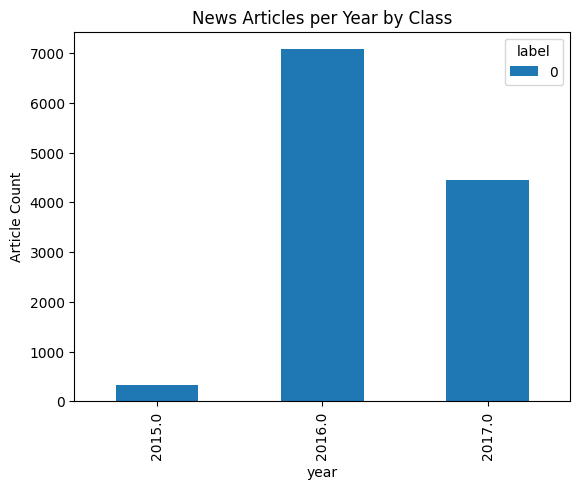

In [19]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Count by year
df.groupby(['year', 'label']).size().unstack().plot(kind='bar', stacked=True)
plt.title("News Articles per Year by Class")
plt.ylabel("Article Count")
plt.show()


In [20]:
print(df.groupby('subject')['label'].value_counts(normalize=True))

subject          label
Government News  0        1.0
Middle-east      0        1.0
News             0        1.0
US_News          0        1.0
left-news        0        1.0
politics         0        1.0
politicsNews     1        1.0
worldnews        1        1.0
Name: proportion, dtype: float64


In [21]:
# Basic preprocessing
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

df['clean_text'] = df['text'].apply(lambda x: clean_text(str(x)))

In [22]:
df['clean_text'] = df['clean_text'].astype(str).fillna("")


In [23]:
Max_Num_Words=20000
Max_Sequence_Length=300
Embadding_Dim=100

In [24]:
tokenizer=keras.preprocessing.text.Tokenizer(num_words=Max_Num_Words)
tokenizer.fit_on_texts(df['clean_text'])


In [25]:
print("Total unique words in the dataset:", len(tokenizer.word_index))


Total unique words in the dataset: 115342


In [26]:
sequences = tokenizer.texts_to_sequences(df['clean_text'])
x = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=Max_Sequence_Length)
y = df['label'].values

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [28]:
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=Max_Num_Words, output_dim=Embadding_Dim, input_shape=(Max_Sequence_Length,)))
model.add(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\SREE\anaconda3\envs\tf-env\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117,377 (8.08 MB)

 Trainable params: 2,117,377 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1, verbose=1)


Epoch 1/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 315s 607ms/step - accuracy: 0.9133 - loss: 0.2167 - val_accuracy: 0.9713 - val_loss: 0.0928
Epoch 2/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 308s 608ms/step - accuracy: 0.9758 - loss: 0.0690 - val_accuracy: 0.9752 - val_loss: 0.0755
Epoch 3/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 311s 615ms/step - accuracy: 0.9931 - loss: 0.0234 - val_accuracy: 0.9816 - val_loss: 0.0634
Epoch 4/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 347s 686ms/step - accuracy: 0.9936 - loss: 0.0203 - val_accuracy: 0.9791 - val_loss: 0.0712
Epoch 5/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 138s 273ms/step - accuracy: 0.9963 - loss: 0.0126 - val_accuracy: 0.9852 - val_loss: 0.0585


In [37]:
# Evaluate the model
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(classification_report(y_test, y_pred_classes, target_names=["Real", "Fake"]))


281/281 ━━━━━━━━━━━━━━━━━━━━ 178s 629ms/step
Accuracy: 0.9851893095768374
[[4654   79]
 [  54 4193]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4733
           1       0.98      0.99      0.98      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



NameError: name 'y_pred_classes' is not defined

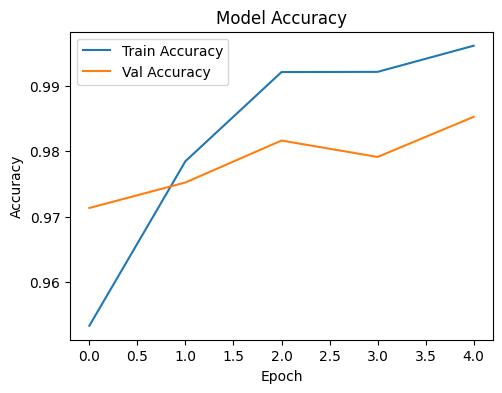

In [31]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

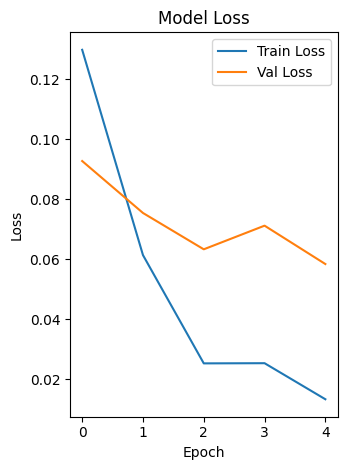

In [32]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


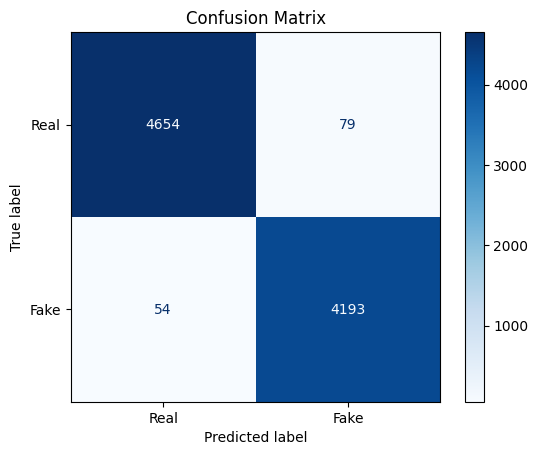

In [36]:


# 1.3. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 1.4. Visualize
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
